In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# for distance and h-clustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform

#Kmeans clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics 
from sklearn.decomposition import PCA

# sklearn does have some functionality too, but mostly a wrapper to scipy
from sklearn.metrics import pairwise_distances 
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('df_merged.csv')
df_ei = pd.read_csv('/Users/maralinetorres/Documents/GitHub/Predicting-Environmental-and-Social-Actions/Datasets/Environmental_impact_cleaned.csv')
stocks = pd.read_csv('/Users/maralinetorres/Documents/GitHub/Predicting-Environmental-and-Social-Actions/Datasets/pilot_stocks.csv')

In [2]:
sectors = pd.read_csv("/Users/maralinetorres/Documents/GitHub/Predicting-Environmental-and-Social-Actions/Datasets/52_tickers_sectors.csv")
stocks['Missing_GHG'] = np.where(stocks['GHG Scope 1'].isna(), 1, 0)
df = pd.merge(stocks, sectors, how='inner',on='Ticker')
df.drop(columns='Name', inplace=True)
stocks = df.copy()
stocks['Utility'] = np.where(stocks.Sector == 'Utilities',1,0)
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780 entries, 0 to 779
Data columns (total 28 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Year                                               780 non-null    int64  
 1   Ticker                                             780 non-null    object 
 2   Environmental Disclosure Score                     636 non-null    float64
 3   GHG Scope 1                                        398 non-null    float64
 4   Total Energy Consumption                           243 non-null    float64
 5   Change_in_EDS                                      589 non-null    float64
 6   Change_in_GHG                                      377 non-null    float64
 7   Change_in_TEC                                      237 non-null    float64
 8   Company                                            780 non-null    object 
 9   Total_Asse

## Data Cleaning - version 1

In [ ]:
stocks_df = stocks.copy()
stocks_df = stocks_df.loc[:, ~stocks_df.columns.isin(['Logarithm_Total_Assets','Logarithm_Total_Sales','Sector','Missing_GHG'])]
stocks_df.loc[np.isinf(stocks_df.Annual_Stock_Return),'Annual_Stock_Return'] = np.nan #We can see infinity values for PSX and FANG, we want null values instead

In [ ]:
stocks_df.describe().T

In [ ]:
## Impute null values with that year industry average
null_columns= stocks_df.columns[stocks_df.isnull().any()]
null_columns = null_columns.tolist()

for column in null_columns:
    stocks_df[column] = stocks_df.groupby(['Year','Utility']).transform('mean')[[column]]

In [ ]:
stocks_df.isna().sum()

In [ ]:
stocks_df = stocks_df.loc[:, ~stocks_df.columns.isin(['Annual_Stock_Return','Change_in_TEC'])]
stocks_df.head()

In [ ]:
is_NaN = stocks_df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = stocks_df[row_has_NaN]
null_columns1= rows_with_NaN.columns[rows_with_NaN.isnull().any()]
null_columns1 = null_columns1.tolist()
null_columns1.append('Year')
rows_with_NaN[null_columns1]

In [ ]:
rows_with_NaN['null_values'] = rows_with_NaN.isnull().sum(axis=1)
rows_with_NaN.head()

plt.figure(figsize=(10,5));
sns.barplot(x='Year', y = 'null_values', data = rows_with_NaN);

In [ ]:
#lets get rid of data from 2005 and 2006 because it is missing data for multiple columns
stocks_df = stocks_df.loc[stocks_df.Year >= 2007, ]
stocks_df.info()

## Hierarchical Clustering - version 1 and utility industry

In [ ]:
# 1) Standarized the data
df = stocks_df[stocks_df.Utility == 1]
stock_number = df.select_dtypes('number')
sc = StandardScaler()
stock_scaled = sc.fit_transform(stock_number)
stock_scaled = pd.DataFrame(stock_scaled, columns = stock_number.columns)
stock_scaled

In [ ]:
#2) Clustering using euclidean and cosine for distance matrix

dc1 = pdist(stock_scaled.values) #euclidean
dc2 = pdist(stock_scaled.values, metric='cosine')

#See now with linkage method and cosine distance matrix work
METHODS = ['single', 'complete', 'average', 'ward']

plt.figure(figsize=(20,5))

for i,m in enumerate(METHODS):
    plt.subplot(1,4,i+1)
    plt.title(m)
    dendrogram(linkage(dc2, method=m),
                leaf_rotation= 90)

In [ ]:
#3 ) See how linkage method and euclidean distance metric work
plt.figure(figsize=(20,5))

for i,m in enumerate(METHODS):
    plt.subplot(1,4,i+1)
    plt.title(m)
    dendrogram(linkage(dc1, method=m),
                leaf_rotation= 90)

I am going to use the cosine and average because the cluster start forming lower and there isnt too much height compared to the other methods. Clusters are more group together and compact 

In [ ]:
#4) Create the labels
hc1 = linkage(dc2, method='average')
plt.title('Dendogram for Cosine and Average')
dendrogram(hc1,
            leaf_rotation= 90)
plt.axhline(linestyle='--', y=.85)
plt.show()

In [ ]:
labels = fcluster(hc1, 3, criterion='maxclust')
np.unique(labels)

In [ ]:
#put the labels into the clean dataset
df['cluster'] = labels
df.head(3) #Review the dataset with the labels

In [ ]:
#How many stocks per cluster
df.cluster.value_counts(dropna=False, sort=False)

When using two clusters... we can see that the number of observations are more balanced. 

In [ ]:
X = stock_scaled.values
sns.scatterplot(X[:,3],X[:,4],hue=df.cluster, cmap="rainbow").set(title='Stock - Hierarchical Clustering')
plt.show()

### K-Means Clustering - version 1 and utility

In [ ]:
#Cluster Evaluation - Deciding how many clusters
X = stock_scaled.values
KRANGE = range(2,10)
sse = []

## loop over and evaluate
for k in KRANGE:
  km = KMeans(k)
  labs = km.fit_predict(stock_scaled)
  sse.append(km.inertia_)

#Elbow Method
sns.lineplot(KRANGE,sse)
plt.show()

In [ ]:
# Testing K
ss1 = []

for k in KRANGE:
  km = KMeans(k)
  lab = km.fit_predict(stock_scaled)
  ss1.append(metrics.silhouette_score(stock_scaled, lab))

sns.lineplot(KRANGE, ss1)
plt.show()

In [ ]:
#It shows 3 clusters are the best option... because it radically descreases when 4.

##K Means for 3
k3 = KMeans(3)
k3.fit(X)
k3_labs = k3.predict(X)

In [ ]:
df['k3'] = k3_labs
df.k3.value_counts(dropna=False, sort=False) #

## Hierarchical Clustering - version 1 and Energy industry

In [ ]:
# 1) Standarized the data
df1 = stocks_df[stocks_df.Utility == 0]
stock_number = df1.select_dtypes('number')
sc = StandardScaler()
stock_scaled = sc.fit_transform(stock_number)
stock_scaled = pd.DataFrame(stock_scaled, columns = stock_number.columns)
stock_scaled

In [ ]:
#2) Clustering using euclidean and cosine for distance matrix

dc1 = pdist(stock_scaled.values) #euclidean
dc2 = pdist(stock_scaled.values, metric='cosine')

#See now with linkage method and cosine distance matrix work
METHODS = ['single', 'complete', 'average', 'ward']

plt.figure(figsize=(20,5))

for i,m in enumerate(METHODS):
    plt.subplot(1,4,i+1)
    plt.title(m)
    dendrogram(linkage(dc2, method=m),
                leaf_rotation= 90)

In [ ]:
#3 ) See how linkage method and euclidean distance metric work
plt.figure(figsize=(20,5))

for i,m in enumerate(METHODS):
    plt.subplot(1,4,i+1)
    plt.title(m)
    dendrogram(linkage(dc1, method=m),
                leaf_rotation= 90)

In [ ]:
#4) Create the labels
hc1 = linkage(dc2, method='average')
plt.title('Dendogram for Cosine and Average')
dendrogram(hc1,
            leaf_rotation= 90)
plt.axhline(linestyle='--', y=.85)
plt.show()

In [ ]:
labels = fcluster(hc1, 2, criterion='maxclust')
np.unique(labels)

In [ ]:
#put the labels into the clean dataset
df1['cluster'] = labels
df1.head(3) #Review the dataset with the labels

In [ ]:
#How many stocks per cluster
df1.cluster.value_counts(dropna=False, sort=False)

## K-Means version 1 and energy industry

In [ ]:
#Cluster Evaluation - Deciding how many clusters
X = stock_scaled.values
KRANGE = range(2,10)
sse = []

## loop over and evaluate
for k in KRANGE:
  km = KMeans(k)
  labs = km.fit_predict(stock_scaled)
  sse.append(km.inertia_)

#Elbow Method
sns.lineplot(KRANGE,sse)
plt.show()

In [ ]:
# Testing K
ss1 = []

for k in KRANGE:
  km = KMeans(k)
  lab = km.fit_predict(stock_scaled)
  ss1.append(metrics.silhouette_score(stock_scaled, lab))

sns.lineplot(KRANGE, ss1)
plt.show()

In [ ]:
#It shows 3 clusters are the best option... because it radically descreases when 4.

##K Means for 3
k3 = KMeans(3)
k3.fit(X)
k3_labs = k3.predict(X)

In [ ]:
df1['k3'] = k3_labs
df1.k3.value_counts(dropna=False, sort=False) #

## Cluster profiling for Utility industry

In [ ]:
df_clus = df.drop(columns=['k3','Utility'])
stock_numeric = df_clus.select_dtypes('number')
stock_numeric

In [ ]:
clus_profile = stock_numeric.groupby("cluster").mean()
clus_profile

In [ ]:
scp = StandardScaler()
cluster_scaled = scp.fit_transform(clus_profile)
cluster_scaled = pd.DataFrame(cluster_scaled, index=clus_profile.index, columns=clus_profile.columns)
plt.figure(figsize=(9,9))
sns.heatmap(cluster_scaled.T, cmap="Blues", center=0)
plt.show()

## Cluster profiling for Energy industry

In [ ]:
df_clus = df1.drop(columns=['cluster','Utility'])
stock_numeric = df_clus.select_dtypes('number')
stock_numeric

In [ ]:
clus_profile = stock_numeric.groupby("k3").mean()
clus_profile

In [ ]:
scp = StandardScaler()
cluster_scaled = scp.fit_transform(clus_profile)
cluster_scaled = pd.DataFrame(cluster_scaled, index=clus_profile.index, columns=clus_profile.columns)
plt.figure(figsize=(9,9))
sns.heatmap(cluster_scaled.T, cmap="Blues", center=0)
plt.show()

## Data Cleaning - version 2

In [3]:
stocks_clean = stocks.copy()
stocks_clean['time_trend'] = stocks_clean.groupby('Ticker').cumcount()
stocks_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780 entries, 0 to 779
Data columns (total 29 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Year                                               780 non-null    int64  
 1   Ticker                                             780 non-null    object 
 2   Environmental Disclosure Score                     636 non-null    float64
 3   GHG Scope 1                                        398 non-null    float64
 4   Total Energy Consumption                           243 non-null    float64
 5   Change_in_EDS                                      589 non-null    float64
 6   Change_in_GHG                                      377 non-null    float64
 7   Change_in_TEC                                      237 non-null    float64
 8   Company                                            780 non-null    object 
 9   Total_Asse

In [4]:
stocks_clean = stocks_clean.loc[stocks_clean['Missing_GHG'] == 0, stocks_clean.columns.isin(['Company','GHG Scope 1','Total_Assets','Total_Sales','Utility'])]
#stocks_clean['Profitable'] = np.where(stocks_clean.Profitable == True, 1, 0)
stocks_clean

,GHG Scope 1,Company,Total_Assets,Total_Sales,Utility
8,32978.0,AMEREN CORP,21042.0,5838.0,1
9,30675.0,AMEREN CORP,22676.0,6053.0,1
10,28548.2,AMEREN CORP,23640.0,6098.0,1
11,26795.6,AMEREN CORP,24699.0,6076.0,1
12,30200.4,AMEREN CORP,25945.0,6177.0,1
...,...,...,...,...,...
775,118000.0,EXXON MOBIL CORP,336758.0,236810.0,0
776,120000.0,EXXON MOBIL CORP,330314.0,197518.0,0
777,117000.0,EXXON MOBIL CORP,348691.0,237162.0,0
778,119000.0,EXXON MOBIL CORP,346196.0,279332.0,0


In [5]:
agg = stocks_clean.groupby('Company')[['GHG Scope 1','Total_Assets','Total_Sales']].mean().reset_index()
stocks_cleaned = pd.merge(agg, stocks_clean, on='Company', how = 'inner',suffixes=('', '_drop'))
stocks_cleaned.drop([col for col in stocks_cleaned.columns if 'drop' in col], axis=1, inplace=True)
stocks_cleaned.drop_duplicates(inplace=True)
stocks_cleaned.head()

,Company,GHG Scope 1,Total_Assets,Total_Sales,Utility
0,AES CORP (THE),66456.888889,37643.333333,14251.555556,1
9,ALLIANT ENERGY CORP,15811.300000,14436.700000,3427.600000,1
14,AMEREN CORP,29028.414286,24878.571429,6063.285714,1
21,AMERICAN ELECTRIC POWER CO,96828.785714,64374.571429,16056.042857,1
28,AMERICAN WATER WORKS CO INC,60.855556,15455.169667,2980.634000,1


In [6]:
stocks_cleaned.shape

(49, 5)

## Hierarchical Clustering - Version 2 and utility industry

In [7]:
# 1) Standarized the data
stocks_clean1 = stocks_cleaned[stocks_cleaned.Utility == 1]
stock_number = stocks_clean1.select_dtypes('number')
sc = StandardScaler()
stock_scaled = sc.fit_transform(stock_number)
stock_scaled = pd.DataFrame(stock_scaled, columns = stock_number.columns)
stock_scaled

,GHG Scope 1,Total_Assets,Total_Sales,Utility
0,1.126271,-0.254604,0.532308,0.0
1,-0.582903,-1.050878,-1.308093,0.0
2,-0.136856,-0.692593,-0.859946,0.0
3,2.151255,0.662608,0.839126,0.0
4,-1.114445,-1.015932,-1.384091,0.0
5,-0.919947,-0.571947,-0.048667,0.0
6,-0.683731,-0.722413,-0.755936,0.0
7,-1.007818,-0.019635,0.247305,0.0
8,0.283401,1.121406,0.358919,0.0
9,0.097059,-0.501885,-0.017759,0.0


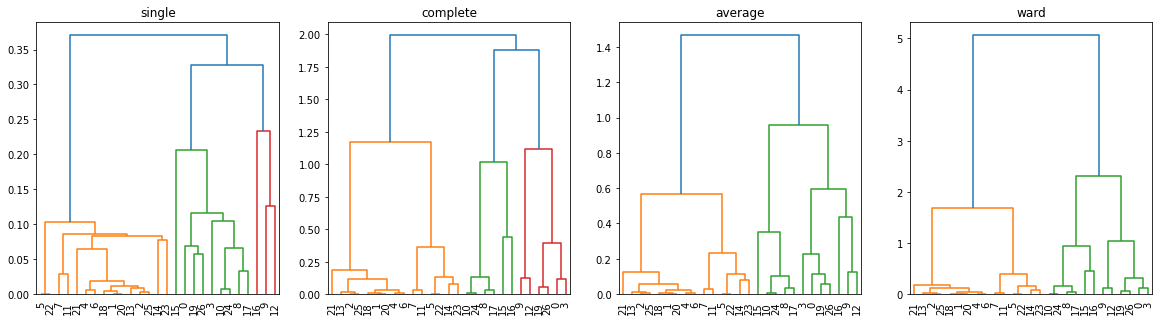

In [8]:
#2) Clustering using euclidean and cosine for distance matrix

dc1 = pdist(stock_scaled.values) #euclidean
dc2 = pdist(stock_scaled.values, metric='cosine')

#See now with linkage method and cosine distance matrix work
METHODS = ['single', 'complete', 'average', 'ward']

plt.figure(figsize=(20,5))

for i,m in enumerate(METHODS):
    plt.subplot(1,4,i+1)
    plt.title(m)
    dendrogram(linkage(dc2, method=m),
                leaf_rotation= 90)

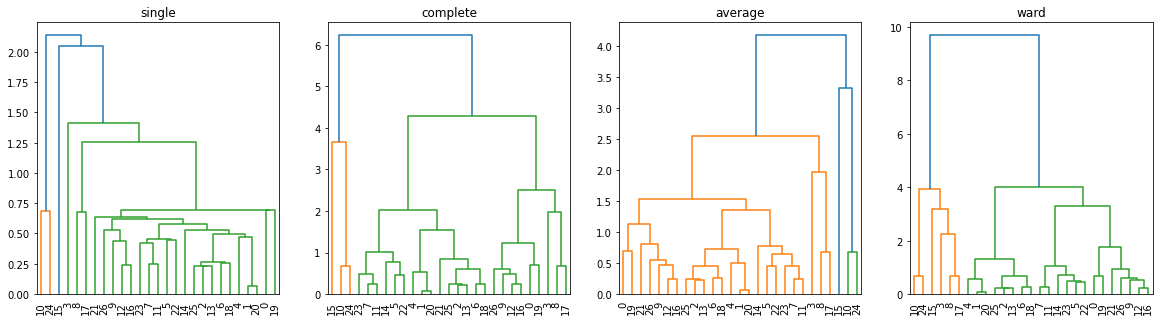

In [9]:
#3 ) See how linkage method and euclidean distance metric work
plt.figure(figsize=(20,5))

for i,m in enumerate(METHODS):
    plt.subplot(1,4,i+1)
    plt.title(m)
    dendrogram(linkage(dc1, method=m),
                leaf_rotation= 90)

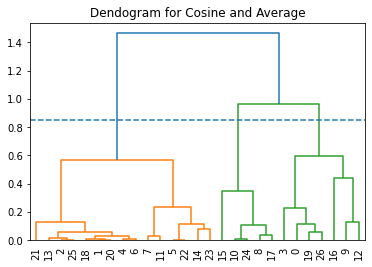

In [10]:
#4) Create the labels
hc1 = linkage(dc2, method='average')
plt.title('Dendogram for Cosine and Average')
dendrogram(hc1,
            leaf_rotation= 90)
plt.axhline(linestyle='--', y=.85)
plt.show()

In [11]:
labels = fcluster(hc1, 3, criterion='maxclust')
np.unique(labels)

array([1, 2, 3], dtype=int32)

In [12]:
#put the labels into the clean dataset
stocks_clean1['cluster'] = labels
stocks_clean1.head(3) #Review the dataset with the labels

,Company,GHG Scope 1,Total_Assets,Total_Sales,Utility,cluster
0,AES CORP (THE),66456.888889,37643.333333,14251.555556,1,3
9,ALLIANT ENERGY CORP,15811.300000,14436.700000,3427.600000,1,1
14,AMEREN CORP,29028.414286,24878.571429,6063.285714,1,1


In [13]:
#How many stocks per cluster
stocks_clean1.cluster.value_counts(dropna=False, sort=False)

1    15
2     5
3     7
Name: cluster, dtype: int64

## K-Means Clustering - Version 2 and utility industry

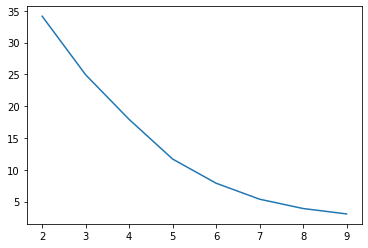

In [14]:
#Cluster Evaluation - Deciding how many clusters
X = stock_scaled.values
KRANGE = range(2,10)
sse = []

## loop over and evaluate
for k in KRANGE:
  km = KMeans(k)
  labs = km.fit_predict(stock_scaled)
  sse.append(km.inertia_)

#Elbow Method
sns.lineplot(KRANGE,sse)
plt.show()

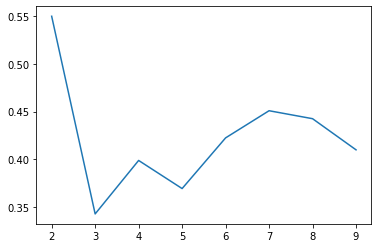

In [15]:
# Testing K
ss1 = []

for k in KRANGE:
  km = KMeans(k)
  lab = km.fit_predict(stock_scaled)
  ss1.append(metrics.silhouette_score(stock_scaled, lab))

sns.lineplot(KRANGE, ss1)
plt.show()

In [16]:
#It shows 3 clusters are the best option... because it radically descreases when 4.

##K Means for 3
k3 = KMeans(3)
k3.fit(X)
k3_labs = k3.predict(X)

In [17]:
stocks_clean1['k3'] = k3_labs
stocks_clean1.k3.value_counts(dropna=False, sort=False) #

0    16
1     3
2     8
Name: k3, dtype: int64

In [18]:
stocks_clean1.to_csv('/Users/maralinetorres/Documents/GitHub/Predicting-Environmental-and-Social-Actions/Datasets/Utility_comp_clustering.csv', index=False)

### Hierarchical Clustering - Version 2 and energy industry

In [19]:
# 1) Standarized the data
stocks_clean2 = stocks_cleaned[stocks_cleaned.Utility == 0]
stock_number = stocks_clean2.select_dtypes('number')
sc = StandardScaler()
stock_scaled = sc.fit_transform(stock_number)
stock_scaled = pd.DataFrame(stock_scaled, columns = stock_number.columns)
stock_scaled

,GHG Scope 1,Total_Assets,Total_Sales,Utility
0,-0.097826,-0.322949,-0.559181,0.0
1,-0.610522,-0.063158,-0.416030,0.0
2,-0.604975,-0.777642,-0.674909,0.0
3,1.647815,2.258538,1.715311,0.0
4,0.682291,0.900561,0.664007,0.0
5,-0.429168,-0.359049,-0.541567,0.0
6,-0.459472,-0.359508,-0.499440,0.0
7,3.858739,3.575635,3.667599,0.0
8,-0.463215,-0.439673,-0.387283,0.0
9,-0.455794,-0.379913,-0.429915,0.0


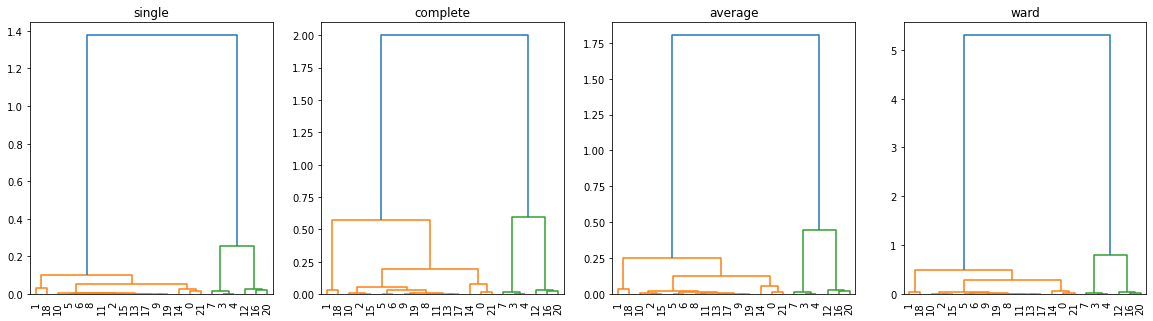

In [20]:
#2) Clustering using euclidean and cosine for distance matrix

dc1 = pdist(stock_scaled.values) #euclidean
dc2 = pdist(stock_scaled.values, metric='cosine')

#See now with linkage method and cosine distance matrix work
METHODS = ['single', 'complete', 'average', 'ward']

plt.figure(figsize=(20,5))

for i,m in enumerate(METHODS):
    plt.subplot(1,4,i+1)
    plt.title(m)
    dendrogram(linkage(dc2, method=m),
                leaf_rotation= 90)

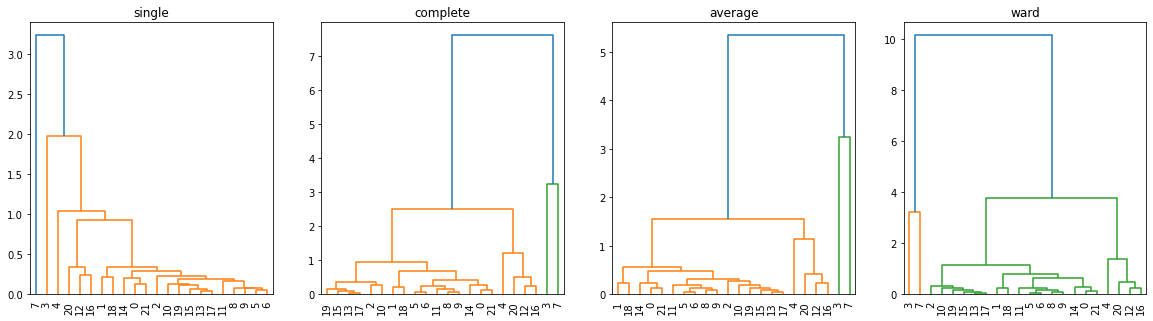

In [21]:
#3 ) See how linkage method and euclidean distance metric work
plt.figure(figsize=(20,5))

for i,m in enumerate(METHODS):
    plt.subplot(1,4,i+1)
    plt.title(m)
    dendrogram(linkage(dc1, method=m),
                leaf_rotation= 90)

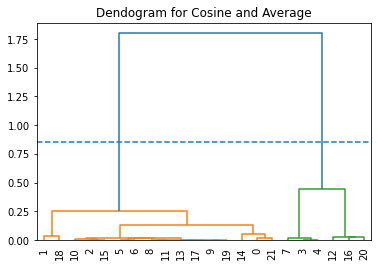

In [22]:
#4) Create the labels
hc1 = linkage(dc2, method='average')
plt.title('Dendogram for Cosine and Average')
dendrogram(hc1,
            leaf_rotation= 90)
plt.axhline(linestyle='--', y=.85)
plt.show()

In [23]:
labels = fcluster(hc1, 2, criterion='maxclust')
np.unique(labels)

array([1, 2], dtype=int32)

In [24]:
#put the labels into the clean dataset
stocks_clean2['cluster'] = labels
stocks_clean2.head(3) #Review the dataset with the labels

,Company,GHG Scope 1,Total_Assets,Total_Sales,Utility,cluster
37,APACHE CORP,14952.566667,36178.852333,10675.480500,0,1
49,BAKER HUGHES CO,373.166667,54286.000000,21324.666667,0,1
52,CABOT OIL & GAS CORP,530.900000,4487.245000,2066.277000,0,1


In [25]:
#How many stocks per cluster
stocks_clean2.cluster.value_counts(dropna=False, sort=False)

1    16
2     6
Name: cluster, dtype: int64

### K-means Clustering - Version 2 and energy industry

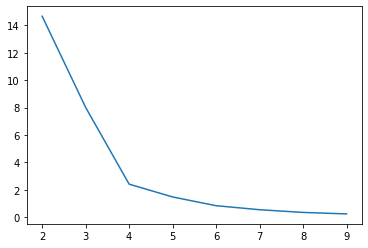

In [26]:
#Cluster Evaluation - Deciding how many clusters
X = stock_scaled.values
KRANGE = range(2,10)
sse = []

## loop over and evaluate
for k in KRANGE:
  km = KMeans(k)
  labs = km.fit_predict(stock_scaled)
  sse.append(km.inertia_)

#Elbow Method
sns.lineplot(KRANGE,sse)
plt.show()

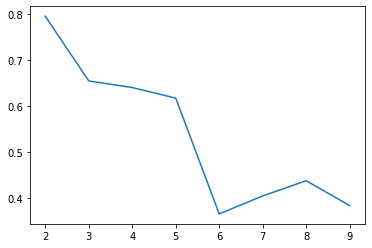

In [27]:
# Testing K
ss1 = []

for k in KRANGE:
  km = KMeans(k)
  lab = km.fit_predict(stock_scaled)
  ss1.append(metrics.silhouette_score(stock_scaled, lab))

sns.lineplot(KRANGE, ss1)
plt.show()

In [28]:
#Let's go with 4 clusters

##K Means for 4
k4 = KMeans(3)
k4.fit(X)
k4_labs = k4.predict(X)

In [29]:
stocks_clean2['k3'] = k4_labs
stocks_clean2.k3.value_counts(dropna=False, sort=False) #

0    16
1     2
2     4
Name: k3, dtype: int64

In [30]:
stocks_clean2.to_csv('/Users/maralinetorres/Documents/GitHub/Predicting-Environmental-and-Social-Actions/Datasets/Energy_comp_clustering.csv', index=False)

## Cluster profiling for version 2 and utility industry

In [31]:
df_clus = stocks_clean1.drop(columns=['k3','Utility'])
stock_numeric = df_clus.select_dtypes('number')
stock_numeric

,GHG Scope 1,Total_Assets,Total_Sales,cluster
0,66456.888889,37643.333333,14251.555556,3
9,15811.300000,14436.700000,3427.600000,1
14,29028.414286,24878.571429,6063.285714,1
21,96828.785714,64374.571429,16056.042857,3
28,60.855556,15455.169667,2980.634000,1
53,5824.166667,28394.666667,10834.666667,1
70,12823.625000,24009.500000,6675.000000,1
88,3220.409091,44491.272727,12575.363636,1
110,41481.280000,77745.800000,13231.800000,2
115,35959.666667,30436.555556,11016.444444,3


In [32]:
clus_profile = stock_numeric.groupby("cluster").mean()
clus_profile

,GHG Scope 1,Total_Assets,Total_Sales
cluster,,,
1,14072.114399,29086.251791,7404.031962
2,60309.799460,98939.217071,20328.243838
3,54375.456363,40817.857028,12508.907826


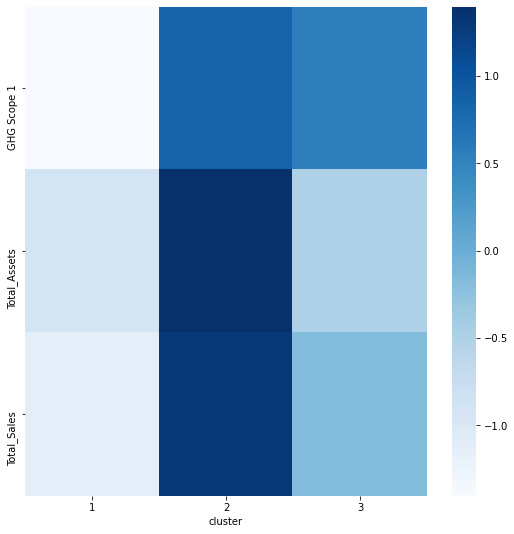

In [33]:
scp = StandardScaler()
cluster_scaled = scp.fit_transform(clus_profile)
cluster_scaled = pd.DataFrame(cluster_scaled, index=clus_profile.index, columns=clus_profile.columns)
plt.figure(figsize=(9,9))
sns.heatmap(cluster_scaled.T, cmap="Blues", center=0)
plt.show()

In [34]:
df_clus1 = stocks_clean1.drop(columns=['cluster','Utility'])
stock_numeric = df_clus1.select_dtypes('number')
stock_numeric

,GHG Scope 1,Total_Assets,Total_Sales,k3
0,66456.888889,37643.333333,14251.555556,2
9,15811.300000,14436.700000,3427.600000,0
14,29028.414286,24878.571429,6063.285714,0
21,96828.785714,64374.571429,16056.042857,2
28,60.855556,15455.169667,2980.634000,0
53,5824.166667,28394.666667,10834.666667,0
70,12823.625000,24009.500000,6675.000000,0
88,3220.409091,44491.272727,12575.363636,0
110,41481.280000,77745.800000,13231.800000,2
115,35959.666667,30436.555556,11016.444444,0


In [35]:
clus_profile = stock_numeric.groupby("k3").mean()
clus_profile

,GHG Scope 1,Total_Assets,Total_Sales
k3,,,
0,15440.086416,29170.645776,7629.807742
1,72052.393266,109801.511785,23920.639731
2,53757.543172,52572.499205,13303.151293


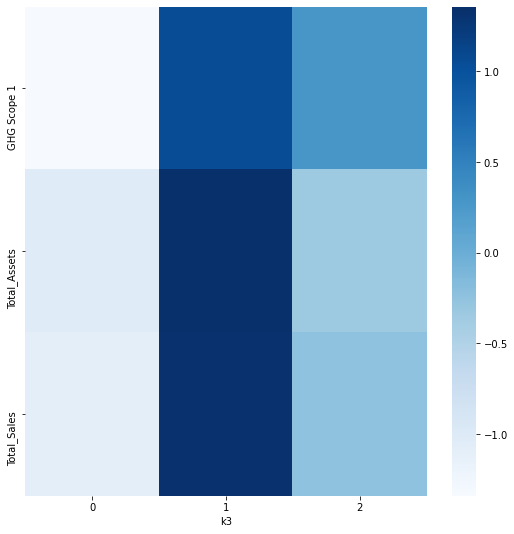

In [36]:
scp = StandardScaler()
cluster_scaled = scp.fit_transform(clus_profile)
cluster_scaled = pd.DataFrame(cluster_scaled, index=clus_profile.index, columns=clus_profile.columns)
plt.figure(figsize=(9,9))
sns.heatmap(cluster_scaled.T, cmap="Blues", center=0)
plt.show()

## Cluster profiling for version 2 and energy industry

In [37]:
df_clus = stocks_clean2.drop(columns=['k3','Utility'])
stock_numeric = df_clus.select_dtypes('number')
stock_numeric

,GHG Scope 1,Total_Assets,Total_Sales,cluster
37,14952.566667,36178.852333,10675.480500,1
49,373.166667,54286.000000,21324.666667,1
52,530.900000,4487.245000,2066.277000,1
56,64592.857143,216105.857143,179877.785714,2
74,37136.521429,121456.214286,101670.000000,2
99,5530.263636,33662.727273,11985.818182,1
155,4668.533333,33630.720000,15119.670000,1
179,127464.285714,307906.142857,325111.000000,2
197,4562.100000,28043.285714,23463.142857,1
204,4773.108333,32208.500000,20291.750000,1


In [38]:
clus_profile = stock_numeric.groupby("cluster").mean()
clus_profile

,GHG Scope 1,Total_Assets,Total_Sales
cluster,,,
1,4984.578172,31384.022544,15947.468311
2,51733.944048,131498.835714,149143.447619


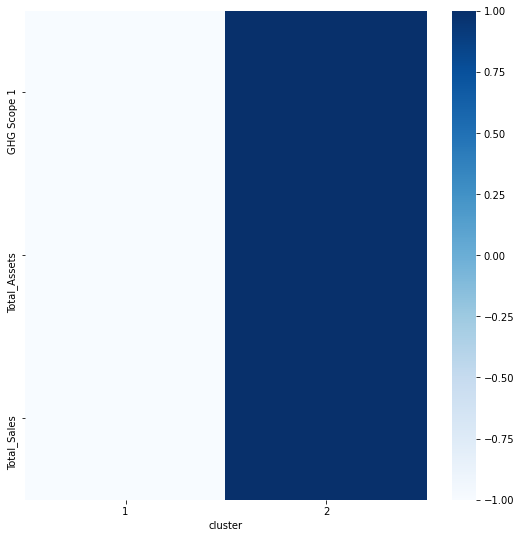

In [39]:
scp = StandardScaler()
cluster_scaled = scp.fit_transform(clus_profile)
cluster_scaled = pd.DataFrame(cluster_scaled, index=clus_profile.index, columns=clus_profile.columns)
plt.figure(figsize=(9,9))
sns.heatmap(cluster_scaled.T, cmap="Blues", center=0)
plt.show()

In [40]:
df_clus = stocks_clean2.drop(columns=['cluster','Utility'])
stock_numeric = df_clus.select_dtypes('number')
stock_numeric

,GHG Scope 1,Total_Assets,Total_Sales,k3
37,14952.566667,36178.852333,10675.480500,0
49,373.166667,54286.000000,21324.666667,0
52,530.900000,4487.245000,2066.277000,0
56,64592.857143,216105.857143,179877.785714,1
74,37136.521429,121456.214286,101670.000000,2
99,5530.263636,33662.727273,11985.818182,0
155,4668.533333,33630.720000,15119.670000,0
179,127464.285714,307906.142857,325111.000000,1
197,4562.100000,28043.285714,23463.142857,0
204,4773.108333,32208.500000,20291.750000,0


In [41]:
clus_profile = stock_numeric.groupby("k3").mean()
clus_profile

,GHG Scope 1,Total_Assets,Total_Sales
k3,,,
0,4984.578172,31384.022544,15947.468311
1,96028.571429,262006.000000,252494.392857
2,29586.630357,66245.253571,97467.975000


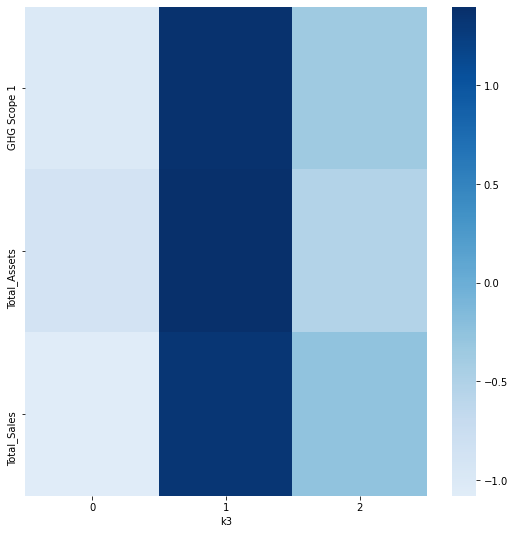

In [42]:
scp = StandardScaler()
cluster_scaled = scp.fit_transform(clus_profile)
cluster_scaled = pd.DataFrame(cluster_scaled, index=clus_profile.index, columns=clus_profile.columns)
plt.figure(figsize=(9,9))
sns.heatmap(cluster_scaled.T, cmap="Blues", center=0)
plt.show()

## Start creating classification score within industry

Utility industry
- Create new column -> GHG Emissions
		○ Cluster 3 --> High
		○ Cluster 2 --> Medium
		○ Cluster 1 --> Low
- Three labels regarding the environmental actions
		○ Improving (Or good)
			§ Last 3 years emissions are below the cluster average
			§ Last 3 years, the % change in GHG scope is descending
			§ Last 3 years, the environmental score higher than cluster average
		○ Neutral
			Last 2 years, emissions are below the cluster average
			Last 2 years, the % change in GHG scope is descending
			Last 2 years, the environmental score higher than cluster average
		○ Deteriorating (Or bad)
            Else, then bad. 

In [43]:
stocks_utility = pd.read_csv('/Users/maralinetorres/Documents/GitHub/Predicting-Environmental-and-Social-Actions/Datasets/Utility_comp_clustering.csv')
stocks_utility.drop(columns='k3', inplace=True)
stocks_utility.head()

,Company,GHG Scope 1,Total_Assets,Total_Sales,Utility,cluster
0,AES CORP (THE),66456.888889,37643.333333,14251.555556,1,3
1,ALLIANT ENERGY CORP,15811.300000,14436.700000,3427.600000,1,1
2,AMEREN CORP,29028.414286,24878.571429,6063.285714,1,1
3,AMERICAN ELECTRIC POWER CO,96828.785714,64374.571429,16056.042857,1,3
4,AMERICAN WATER WORKS CO INC,60.855556,15455.169667,2980.634000,1,1


In [44]:
stocks_utility_num = stocks_utility.select_dtypes('number')
clus_profile = stocks_utility_num.groupby("cluster").mean()
clus_profile.sort_values(by='GHG Scope 1')

,GHG Scope 1,Total_Assets,Total_Sales,Utility
cluster,,,,
1,14072.114399,29086.251791,7404.031962,1
3,54375.456363,40817.857028,12508.907826,1
2,60309.799460,98939.217071,20328.243838,1


In [45]:
min_ghg = clus_profile['GHG Scope 1'].min()
max_ghg = clus_profile['GHG Scope 1'].max()

conditions = [ (clus_profile['GHG Scope 1'] == min_ghg),
              (clus_profile['GHG Scope 1'] == max_ghg), 
               (clus_profile['GHG Scope 1'].between(left=min_ghg, right=max_ghg))]
choices = ['Low', 'High','Medium']

clus_profile['GHG_Emission_category'] = np.select(condlist=conditions, choicelist=choices)

In [47]:
clus_profile

,cluster,GHG Scope 1,Total_Assets,Total_Sales,Utility,GHG_Emission_category
0,1,14072.114399,29086.251791,7404.031962,1,Low
1,3,54375.456363,40817.857028,12508.907826,1,Medium
2,2,60309.799460,98939.217071,20328.243838,1,High


In [46]:
clus_profile = clus_profile.sort_values(by='GHG Scope 1').reset_index()
clus_profile1 = clus_profile[['cluster','GHG_Emission_category']]
clus_profile1

,cluster,GHG_Emission_category
0,1,Low
1,3,Medium
2,2,High


In [48]:
cluster_stocks = pd.merge(stocks_utility, clus_profile1, on='cluster',how = 'inner')
cluster_stocks.head()

,Company,GHG Scope 1,Total_Assets,Total_Sales,Utility,cluster,GHG_Emission_category
0,AES CORP (THE),66456.888889,37643.333333,14251.555556,1,3,Medium
1,AMERICAN ELECTRIC POWER CO,96828.785714,64374.571429,16056.042857,1,3,Medium
2,DTE ENERGY CO,35959.666667,30436.555556,11016.444444,1,3,Medium
3,ENTERGY CORP,33786.523077,42877.418154,11349.992538,1,3,Medium
4,FIRSTENERGY CORP,34874.625000,41942.250000,12717.500000,1,3,Medium


In [49]:
def assignEnvironmentalScoreLabel(stocks, companies, cluster_stocks, clus_profile):
    companies = cluster_stocks.Company.tolist()
    company_label_score = {}
    for com in companies:
        data = stocks.loc[stocks.Company == com]
        clust_num = cluster_stocks.loc[cluster_stocks.Company == com,'cluster'].tolist()
        avg_ghg_scope = clus_profile[clus_profile.cluster == clust_num[0]]['GHG Scope 1'].tolist()
        year_max = data.Year.max()
        year_min = year_max - 2
        
        assigned = checkMetrics(year_max, year_min, data, 'Improving/Good', company_label_score, com, avg_ghg_scope, companies)
        
        if assigned == False:
            year_min = year_max - 1
            data = stocks.loc[stocks.Company == com]
            assigned = checkMetrics(year_max, year_min, data, 'Neutral', company_label_score, com, avg_ghg_scope, companies)
            if assigned == False:
                company_label_score[com] = 'Bad forecast'
    return company_label_score

In [50]:
def checkMetrics(maxYear, min_year, data, label, company_label_score, com, avg_ghg_scope, companies):
    success = False
    com_trend = data.loc[(data.Year <= maxYear) & (data.Year >= min_year), ['Year','Change_in_GHG','Environmental Disclosure Score','GHG Scope 1']]
    change_ghg = com_trend['Change_in_GHG'].tolist()
    res = all(abs(i) > abs(j) for i, j in zip(change_ghg, change_ghg[1:]))
    if res == True:
        ghg_scope = com_trend['GHG Scope 1'].tolist()
        res_ghg = all(i < avg_ghg_scope[0] for i in ghg_scope)
        if res_ghg == True:
            eds_list = com_trend['Environmental Disclosure Score'].tolist()
            eds = stocks.loc[(stocks.Company.isin(companies))&(stocks.Year <= maxYear) & 
                             (stocks.Year >= min_year),['Environmental Disclosure Score']].mean().tolist()
            res_eds = all(i < eds[0] for i in eds_list)
            if res_eds == True:
                company_label_score[com] = label
                success = True
    return success

In [52]:
companies = cluster_stocks.Company.tolist()

In [53]:
assignEnvironmentalScoreLabel(stocks,companies,cluster_stocks, clus_profile)

{'AES CORP (THE)': 'Bad forecast',
 'AMERICAN ELECTRIC POWER CO': 'Bad forecast',
 'DTE ENERGY CO': 'Bad forecast',
 'ENTERGY CORP': 'Neutral',
 'FIRSTENERGY CORP': 'Bad forecast',
 'NRG ENERGY INC': 'Bad forecast',
 'XCEL ENERGY INC': 'Bad forecast',
 'ALLIANT ENERGY CORP': 'Bad forecast',
 'AMEREN CORP': 'Bad forecast',
 'AMERICAN WATER WORKS CO INC': 'Bad forecast',
 'CENTERPOINT ENERGY INC': 'Neutral',
 'CMS ENERGY CORP': 'Bad forecast',
 'CONSOLIDATED EDISON INC': 'Bad forecast',
 'EDISON INTERNATIONAL': 'Neutral',
 'EVERGY INC': 'Bad forecast',
 'EVERSOURCE ENERGY': 'Bad forecast',
 'NISOURCE INC': 'Bad forecast',
 'PINNACLE WEST CAPITAL CORP': 'Bad forecast',
 'PPL CORP': 'Bad forecast',
 'PUBLIC SERVICE ENTRP GRP INC': 'Bad forecast',
 'SEMPRA ENERGY': 'Bad forecast',
 'WEC ENERGY GROUP INC': 'Bad forecast',
 'DOMINION ENERGY INC': 'Bad forecast',
 'DUKE ENERGY CORP': 'Bad forecast',
 'EXELON CORP': 'Bad forecast',
 'NEXTERA ENERGY INC': 'Bad forecast',
 'SOUTHERN CO': 'Bad for

In [ ]:
assignEnvironmentalScoreLabel(stocks,['AES CORP (THE)'],cluster_stocks, clus_profile)